# MERSCOPE Analysis

In [403]:
# Import necessary libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import geopandas as gpd # For .parquet file with geometries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # For displaying images
import seaborn as sns
import numpy as np # For calculations if needed
import os
import squidpy
import warnings

# Suppress FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)

In [404]:
os.chdir("/beegfs/scratch/ric.sessa/kubacki.michal/SRF_Linda/SRF_Spatial_segmentation")

# Define file paths
base_path = 'DATA/p0-p7/R2'
h5ad_file = os.path.join(base_path, 'data.h5ad')

## 1. Data Loading

In [405]:
# Attempt to load the .h5ad file
adata = None
try:
    adata = sc.read_h5ad(h5ad_file)
    print(f"Successfully loaded AnnData file: {h5ad_file}")
    print(adata)
except FileNotFoundError:
    print(f"AnnData file not found: {h5ad_file}. Will attempt to load individual files.")
except Exception as e:
    print(f"Error loading AnnData file {h5ad_file}: {e}. Will attempt to load individual files.")

Successfully loaded AnnData file: DATA/p0-p7/R2/data.h5ad
AnnData object with n_obs × n_vars = 53513 × 960
    obs: 'volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden'
    var: 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [406]:
print(adata.obs.index[:5])
print(adata.obs.volume.head())
print(adata.obs.center_x.head())
print(adata.obs.leiden.head())

Index(['2073004400000100013', '2073004400000100014', '2073004400000100015',
       '2073004400000100016', '2073004400000100017'],
      dtype='object', name='cell')
cell
2073004400000100013    1218.137668
2073004400000100014    1400.993473
2073004400000100015     532.221979
2073004400000100016    1232.070168
2073004400000100017    1750.479655
Name: volume, dtype: float64
cell
2073004400000100013    4702.962251
2073004400000100014    4715.649671
2073004400000100015    4586.625783
2073004400000100016    4633.723622
2073004400000100017    4684.406760
Name: center_x, dtype: float64
cell
2073004400000100013     0
2073004400000100014    12
2073004400000100015     0
2073004400000100016     0
2073004400000100017     8
Name: leiden, dtype: category
Categories (21, object): ['0', '1', '2', '3', ..., '17', '18', '19', '20']


In [407]:
keep_genes = [x for x in adata.var.index.tolist() if 'Blank' not in x]
print(len(keep_genes))
print(adata.shape[1])

960
960


In [408]:
min_expression = 25
ser_exp = adata.to_df().sum(axis=1)

keep_cells = ser_exp[ser_exp > min_expression].index.tolist()
print(len(keep_cells))
print(adata.shape[0])

# adata = adata[keep_cells]
# adata

53513
53513


In [409]:
adata_v2 = adata.copy()

# 1b Supplementary files

## Count data

In [410]:
cell_by_gene_file = os.path.join(base_path, 'cell_by_gene.csv')

In [411]:
# Load gene expression data
counts_df = pd.read_csv(cell_by_gene_file, index_col=0) # Assuming first column is cell ID
print(f"Loaded {cell_by_gene_file}: {counts_df.shape[0]} cells, {counts_df.shape[1]} genes")
non_zero_values = counts_df.values[counts_df.values != 0]
top_5_values = sorted(non_zero_values, reverse=True)[:5]
print("Top 5 non-zero values:", top_5_values)

Loaded DATA/p0-p7/R2/cell_by_gene.csv: 54260 cells, 1000 genes
Top 5 non-zero values: [144, 138, 125, 122, 121]


## Metadata

In [412]:
cell_metadata_file = os.path.join(base_path, 'cell_metadata.csv')

In [413]:
# Load cell metadata
metadata_df = pd.read_csv(cell_metadata_file, index_col=0) # Assuming first column is cell ID
print(f"Loaded {cell_metadata_file}: {metadata_df.shape[0]} cells, {metadata_df.shape[1]} metadata columns")
metadata_df.head()

Loaded DATA/p0-p7/R2/cell_metadata.csv: 54260 cells, 28 metadata columns


,fov,volume,center_x,center_y,min_x,min_y,max_x,max_y,anisotropy,transcript_count,...,Ttr_raw,Ttr_high_pass,Pcp4_raw,Pcp4_high_pass,Anti-SETBP1_raw,Anti-SETBP1_high_pass,hSETBP1_raw,hSETBP1_high_pass,PolyT_raw,PolyT_high_pass
EntityID,,,,,,,,,,,,,,,,,,,,,
2073004400000100003,672,703.657150,4581.018292,208.549651,4576.426889,201.996751,4585.580076,214.345463,1.857992,5,...,117865030.0,8.548601e+05,67934877.0,8.548428e+05,22490886.0,376865.889964,56866753.0,6.767775e+05,380592710.0,4.022168e+06
2073004400000100013,646,1218.137668,4702.962251,216.144254,4698.049325,206.915874,4708.389729,224.132029,2.000764,191,...,187662659.0,1.418204e+06,134619985.0,2.352428e+06,37170198.0,706287.808846,99358850.0,1.047688e+06,343236184.0,3.741490e+06
2073004400000100014,646,1400.993473,4715.649671,213.938956,4707.998522,207.808330,4723.487770,220.333874,1.510526,205,...,253422860.0,1.672426e+06,188463182.0,3.372530e+06,47427793.0,862425.292340,127510827.0,1.339939e+06,523583864.0,3.711269e+06
2073004400000100015,672,532.221979,4586.625783,213.220325,4582.661293,208.403721,4590.306955,217.525916,1.296490,51,...,85538693.0,7.105556e+05,50915358.0,7.846359e+05,17302828.0,297563.217790,41359504.0,5.026054e+05,232728854.0,2.151503e+06
2073004400000100016,646,1232.070168,4633.723622,214.359044,4626.536637,208.919505,4640.900895,219.596483,1.347108,185,...,164724630.0,1.074719e+06,103360538.0,1.510494e+06,34723617.0,669625.901206,89527534.0,8.946606e+05,303445713.0,2.745901e+06


In [414]:
# Align indices (important!)
common_cells = counts_df.index.intersection(metadata_df.index)
counts_df = counts_df.loc[common_cells]
metadata_df = metadata_df.loc[common_cells]
print(f"Found {len(common_cells)} common cells between counts and metadata.")

if len(common_cells) == 0:
    raise ValueError("No common cells found between cell_by_gene.csv and cell_metadata.csv. Cannot create AnnData object.")

Found 54260 common cells between counts and metadata.


In [415]:
# Create AnnData object
# adata = ad.AnnData(X=counts_df.values, obs=metadata_df, var=pd.DataFrame(index=counts_df.columns))
# adata.X = adata.X.astype('float32') # Ensure X is float for scanpy operations
# print("Successfully created AnnData object from CSV files.")
# print(adata)

### Cell boundaries

In [416]:
cell_boundaries_file = os.path.join(base_path, 'cell_boundaries.parquet')
cell_boundaries_gdf = None

In [417]:
cell_boundaries_gdf = gpd.read_parquet(cell_boundaries_file)
print(f"Loaded {cell_boundaries_file}. Shape: {cell_boundaries_gdf.shape}")

Loaded DATA/p0-p7/R2/cell_boundaries.parquet. Shape: (379820, 9)


In [418]:
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
0,0,2073004400000100003,3,"MULTIPOLYGON (((4577.127 213.444, 4577.653 214...",None,None,cell,6.0,None
1,1,2073004400000100013,3,"MULTIPOLYGON (((4700.266 214.565, 4700.113 217...",None,None,cell,6.0,None
2,2,2073004400000100014,3,"MULTIPOLYGON (((4714.439 220.304, 4717.441 218...",None,None,cell,6.0,None
3,3,2073004400000100015,3,"MULTIPOLYGON (((4582.661 213.587, 4584.364 216...",None,None,cell,6.0,None
4,4,2073004400000100016,3,"MULTIPOLYGON (((4628.379 217.812, 4629.837 218...",None,None,cell,6.0,None


In [419]:
cell_boundaries_gdf = cell_boundaries_gdf.set_index('EntityID', drop=False)
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
EntityID,,,,,,,,,
2073004400000100003,0,2073004400000100003,3,"MULTIPOLYGON (((4577.127 213.444, 4577.653 214...",None,None,cell,6.0,None
2073004400000100013,1,2073004400000100013,3,"MULTIPOLYGON (((4700.266 214.565, 4700.113 217...",None,None,cell,6.0,None
2073004400000100014,2,2073004400000100014,3,"MULTIPOLYGON (((4714.439 220.304, 4717.441 218...",None,None,cell,6.0,None
2073004400000100015,3,2073004400000100015,3,"MULTIPOLYGON (((4582.661 213.587, 4584.364 216...",None,None,cell,6.0,None
2073004400000100016,4,2073004400000100016,3,"MULTIPOLYGON (((4628.379 217.812, 4629.837 218...",None,None,cell,6.0,None


In [420]:
# adata.obs.index = adata.obs.index.astype(str)
# cell_boundaries_gdf.index = cell_boundaries_gdf.index.astype(str)

# print(adata.obs.index[:5])
# print(cell_boundaries_gdf.index[:5])

In [421]:
# common_cells_boundaries = adata.obs.index.intersection(cell_boundaries_gdf.index)
# common_cells_boundaries[:5]

In [422]:
# adata.uns['cell_boundaries_gdf'] = cell_boundaries_gdf.loc[common_cells_boundaries]

## Differentially expressed genes

In [423]:
differentially_expressed_genes_file = os.path.join(base_path, 'differentially_expressed_genes.csv')

In [424]:
degs_df = pd.read_csv(differentially_expressed_genes_file, index_col=0)
print(degs_df.shape)
print(adata.shape)

(20160, 5)
(53513, 960)


In [425]:
degs_df.head()

,gene,cluster_id,p_value,fold_change,adjusted_p_value
402,Abl1,0,1.610356e-04,-0.365063,2.180454e-04
870,Ablim1,0,2.086226e-134,-1.682992,1.440847e-133
845,Acsl1,0,1.096598e-97,-1.704004,5.914237e-97
578,Acta2,0,6.984303e-14,-2.103555,1.330343e-13
819,Adcy1,0,3.245439e-77,-0.899928,1.490728e-76


In [426]:
print(len(degs_df.gene.unique()))

960


In [427]:
degs_df = degs_df.set_index('gene', drop=False)
degs_df.shape

(20160, 5)

In [428]:
print(degs_df.index[:5])
print(adata.var.index[:5])

Index(['Abl1', 'Ablim1', 'Acsl1', 'Acta2', 'Adcy1'], dtype='object', name='gene')
Index(['Gnai3', 'Ngfr', 'Wnt3', 'Ccnd2', 'Lhx2'], dtype='object')


In [429]:
adata.var.index = adata.var.index.astype(str)
degs_df.index = degs_df.index.astype(str)

In [430]:
common_genes = adata.var.index.intersection(degs_df.index)
len(common_genes)

960

In [431]:
# adata.uns['cell_boundaries_gdf'] = degs_df.loc[common_genes]

## Detected transcripts

In [432]:
detected_transcripts_file = os.path.join(base_path, 'detected_transcripts.parquet')

In [433]:
det_trans_df = pd.read_parquet(detected_transcripts_file)
det_trans_df.shape

(11602210, 11)

In [434]:
det_trans_df.head()

,,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
0,1,9,8650.356445,829.075439,0.0,253.560684,238.439316,250,Pdgfra,ENSMUST00000000476,-1
1,12,83,8653.042969,850.087952,0.0,278.440308,433.000000,250,Mdh2,ENSMUST00000019323,2073004400017100036
2,8,89,8650.763672,856.911377,0.0,257.330048,496.179443,250,Fabp7,ENSMUST00000020024,-1
3,0,98,8647.158203,844.384827,0.0,223.946716,380.193085,250,Adcy1,ENSMUST00000020706,2073004400017100036
4,1,155,8646.299805,844.039978,0.0,216.000000,377.000000,250,Grk2,ENSMUST00000025791,-1


## Cell categories

In [435]:
cell_categories_file = os.path.join(base_path, 'cell_categories.csv')
cell_numeric_categories_file = os.path.join(base_path, 'cell_numeric_categories.csv')

In [436]:
cell_categories_df = pd.read_csv(cell_categories_file, index_col=0) # Assuming first column is cell ID
cell_numeric_categories_df = pd.read_csv(cell_numeric_categories_file, index_col=0) # Assuming first column is cell ID

In [437]:
cell_categories_df.head()

,leiden
EntityID,
2073004400000100013,0
2073004400000100014,12
2073004400000100015,0
2073004400000100016,0
2073004400000100017,8


In [438]:
cell_numeric_categories_df.head()

,umap_X,umap_Y
EntityID,,
2073004400000100013,13.496558,-0.127429
2073004400000100014,-13.955081,4.962116
2073004400000100015,14.757217,3.935184
2073004400000100016,16.712006,-0.741821
2073004400000100017,12.801692,15.980372


# 2. Exploratory Data Analysis

Basic statistics and distributions of the data.

In [439]:
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

Number of cells: 53513
Number of genes: 960


In [440]:
print("Calculating QC metrics (total_counts, n_genes_by_counts)...")
sc.pp.calculate_qc_metrics(adata, inplace=True)

Calculating QC metrics (total_counts, n_genes_by_counts)...


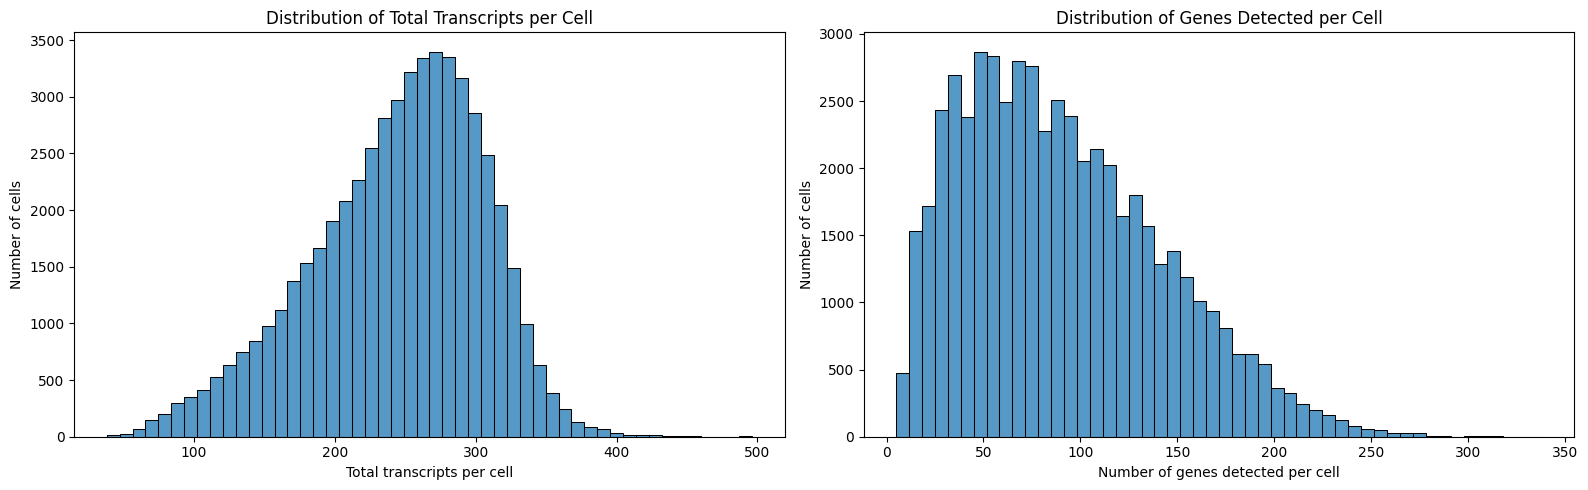

In [441]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot for total_counts
sns.histplot(adata.obs['total_counts'], bins=50, kde=False, ax=axes[0])
axes[0].set_xlabel("Total transcripts per cell")
axes[0].set_ylabel("Number of cells")
axes[0].set_title("Distribution of Total Transcripts per Cell")

# Plot for n_genes_by_counts
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=False, ax=axes[1])
axes[1].set_xlabel("Number of genes detected per cell")
axes[1].set_ylabel("Number of cells")
axes[1].set_title("Distribution of Genes Detected per Cell")

plt.tight_layout()
plt.show()

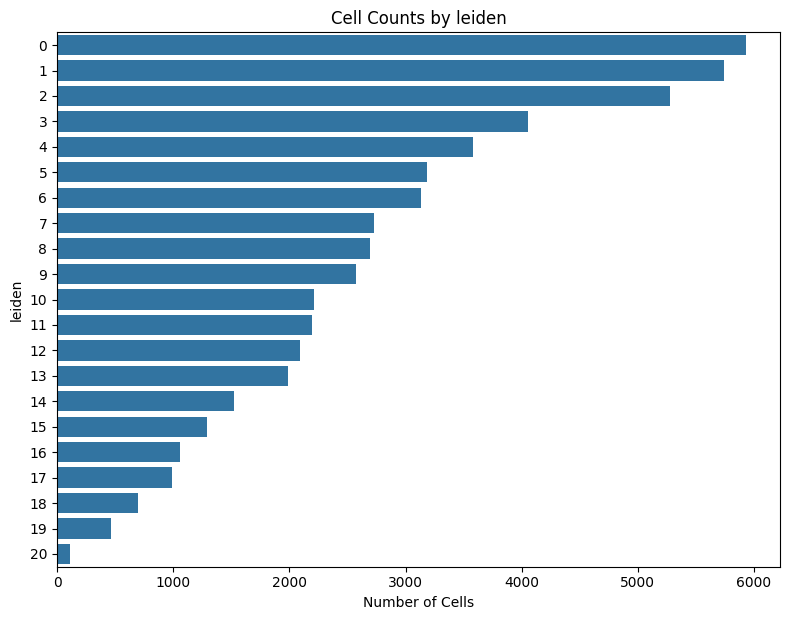

In [442]:
coll_to_summary = 'leiden'

if adata.obs[coll_to_summary].nunique() < 30 and adata.obs[coll_to_summary].nunique() > 1:
    plt.figure(figsize=(8, max(4, adata.obs[coll_to_summary].nunique() * 0.3)))
    sns.countplot(y=adata.obs[coll_to_summary], order = adata.obs[coll_to_summary].value_counts(dropna=False).index)
    plt.title(f"Cell Counts by {coll_to_summary}")
    plt.xlabel("Number of Cells")
    plt.ylabel(coll_to_summary)
    plt.tight_layout()
    plt.show()

## 3. Visualization

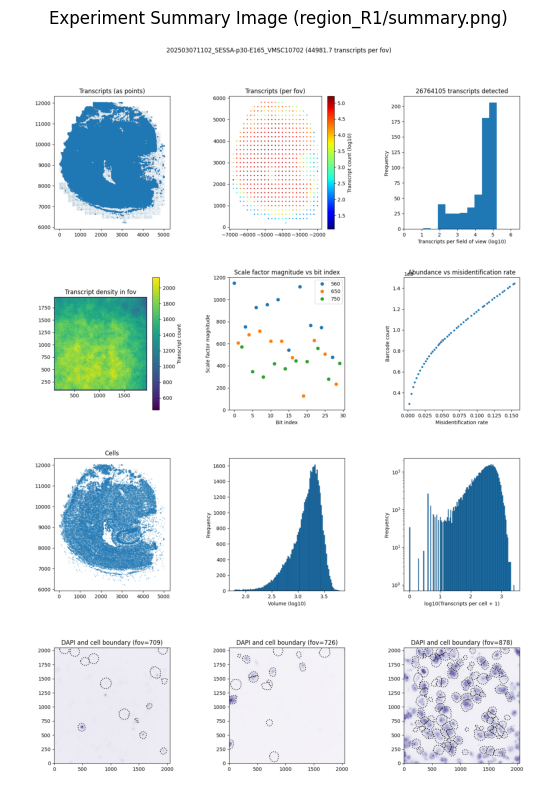

In [443]:
img = mpimg.imread(summary_image_file)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off') # Turn off axis numbers and ticks
plt.title("Experiment Summary Image (region_R1/summary.png)")
plt.show()

In [444]:
print(adata.obsm_keys())
print(list(adata.obs.columns))

['X_pca', 'X_umap']
['volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes']


In [445]:
adata.obsm['spatial'] = adata.obs[['center_x', 'center_y']].to_numpy()
spatial_coords_available = True

<Figure size 1000x1000 with 0 Axes>

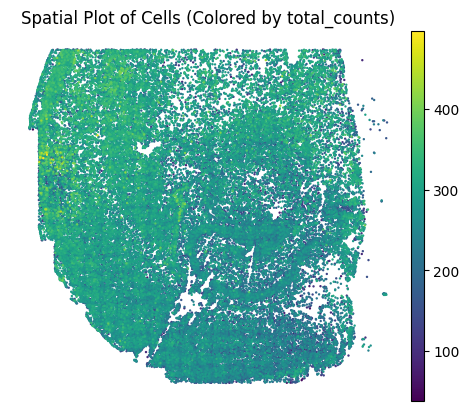

<Figure size 1000x1000 with 0 Axes>

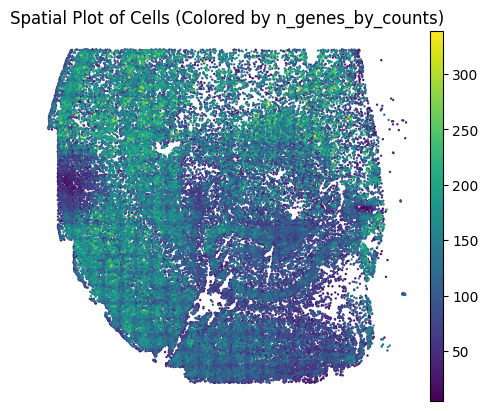

<Figure size 1000x1000 with 0 Axes>

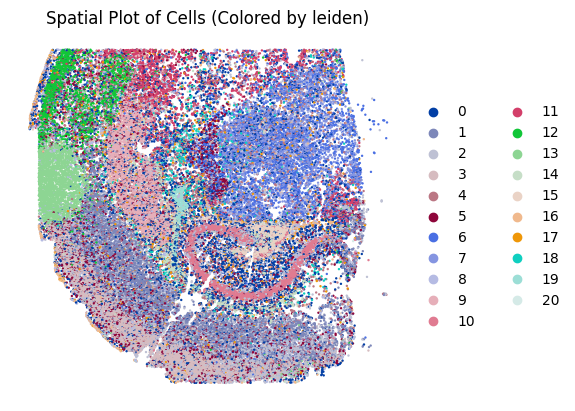

In [446]:
features = ['total_counts', 'n_genes_by_counts', 'leiden']
for color_by in features:
    plt.figure(figsize=(10, 10))
    sc.pl.spatial(adata, color=color_by, spot_size=30, show=False, frameon=False)
    plt.title(f"Spatial Plot of Cells (Colored by {color_by if color_by else 'default'})")
    plt.show()

In [447]:
print(list(adata.var.columns))
print(list(adata.uns))

['mean', 'std', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']
['leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'leiden_colors']


In [448]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor='cell_ranger')

In [449]:
import numpy as np
import scipy.sparse

print(f"adata.X data type: {adata.X.dtype}")

if scipy.sparse.issparse(adata.X):
    print(adata.X[:5, :5].toarray())
    if adata.X.nnz > 0: # nnz is number of stored_elements
        print(f"Min non-zero value in adata.X: {adata.X.data.min()}")
        print(f"Max non-zero value in adata.X: {adata.X.data.max()}")
        has_nan_sparse = np.isnan(adata.X.data).any()
        has_inf_sparse = np.isinf(adata.X.data).any()
        print(f"adata.X.data contains NaNs: {has_nan_sparse}")
        print(f"adata.X.data contains Infs: {has_inf_sparse}")

else: # Dense array
    print(adata.X[:5, :5])
    print(f"Min value in adata.X: {adata.X.min()}")
    print(f"Max value in adata.X: {adata.X.max()}")
    has_nan_dense = np.isnan(adata.X).any()
    has_inf_dense = np.isinf(adata.X).any()
    print(f"adata.X contains NaNs: {has_nan_dense}")
    print(f"adata.X contains Infs: {has_inf_dense}")

adata.X data type: float32
[[0.        0.        0.        1.7006867 0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        2.8780136 0.       ]
 [0.        0.        0.        0.        0.       ]]
Min value in adata.X: 0.0
Max value in adata.X: 74.37686920166016
adata.X contains NaNs: False
adata.X contains Infs: False


Plotting spatial expression for HVGs: ['Wnt3', 'Itgb2', 'Cdh1']


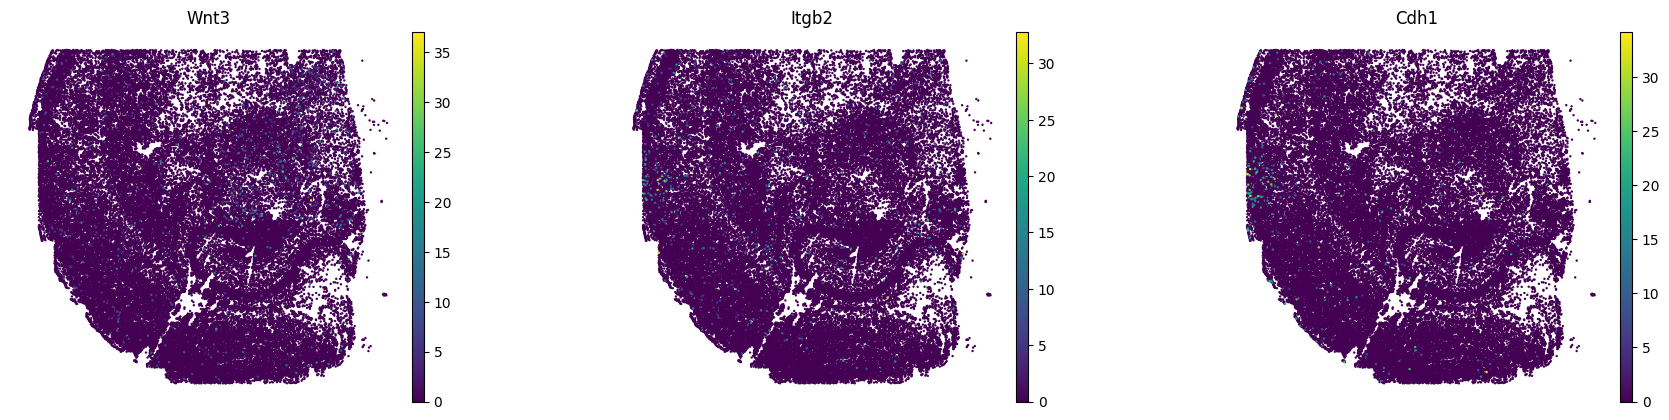

In [ ]:
hvg_genes = adata.var_names[adata.var['highly_variable']].tolist()
if len(hvg_genes) > 0:
    num_genes_to_plot = min(len(hvg_genes), 3)
    genes_to_plot = hvg_genes[:num_genes_to_plot]
    print(f"Plotting spatial expression for HVGs: {genes_to_plot}")
    sc.pl.spatial(adata, color=genes_to_plot, spot_size=30, show=True, frameon=False, ncols=num_genes_to_plot)
else:
    print("No highly variable genes found after computation.")



/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


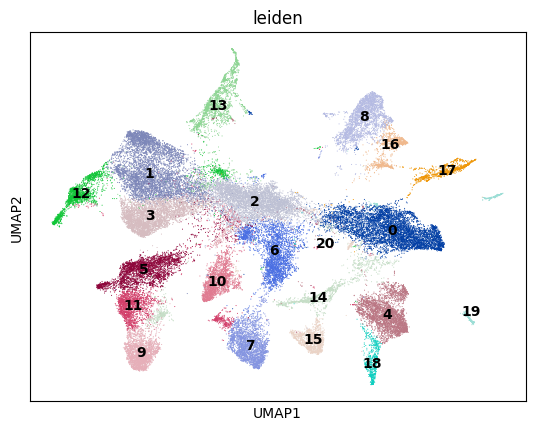

In [451]:
# generate colors for categories by plotting
sc.pl.umap(adata, color="leiden", legend_loc='on data')
cats = adata.obs['leiden'].cat.categories.tolist()
colors = list(adata.uns['leiden_colors'])
cat_colors = dict(zip(cats, colors))

# colors for clustergrammer2
ser_color = pd.Series(cat_colors)
ser_color.name = 'color'
df_colors = pd.DataFrame(ser_color)
df_colors.index = ['Leiden-' + str(x) for x in df_colors.index.tolist()]

df_colors.loc[''] = 'white'

# 3. Alternative DEGs

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


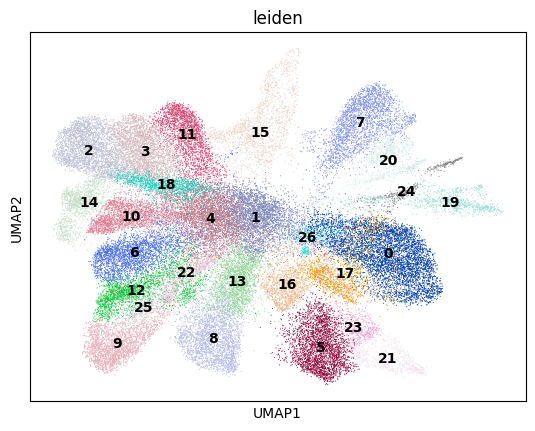

In [452]:
resolution = 1.5

# Leiden Clustering
######################

# dividing by volume instead
sc.pp.normalize_total(adata_v2)
sc.pp.log1p(adata_v2)
sc.pp.scale(adata_v2, max_value=10)
sc.tl.pca(adata_v2, svd_solver='arpack')
sc.pp.neighbors(adata_v2, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata_v2)
sc.tl.leiden(adata_v2, resolution=resolution)

# Calculate Leiden Signatures
#########################################df_pos.index = [str(x) for x in list(range(df_pos.shape[0]))]
ser_counts = adata_v2.obs['leiden'].value_counts()
ser_counts.name = 'cell counts'
meta_leiden = pd.DataFrame(ser_counts)

cat_name = 'leiden'
sig_leiden = pd.DataFrame(columns=adata_v2.var_names, index=adata_v2.obs[cat_name].cat.categories)
for clust in adata_v2.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = adata_v2[adata_v2.obs[cat_name].isin([clust]),:].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ['Leiden-' + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden['leiden'] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())

# generate colors for categories by plotting
sc.pl.umap(adata_v2, color="leiden", legend_loc='on data')
cats = adata_v2.obs['leiden'].cat.categories.tolist()
colors = list(adata_v2.uns['leiden_colors'])
cat_colors = dict(zip(cats, colors))

# colors for clustergrammer2
ser_color = pd.Series(cat_colors)
ser_color.name = 'color'
df_colors = pd.DataFrame(ser_color)
df_colors.index = ['Leiden-' + str(x) for x in df_colors.index.tolist()]

df_colors.loc[''] = 'white'

# R. ROI

In [ ]:
roi_file = "E:/Githubs/SPATIAL_data/202503071102_SESSA-p30-E165_VMSC10702/R4/p30_CTRL_R4/cells1.csv"
roi_data = pd.read_csv(roi_file)
cell1_ids = roi_data.iloc[:, 0].astype(str).tolist()
cell1_ids[:5]

In [ ]:
roi_file = "E:/Githubs/SPATIAL_data/202503071102_SESSA-p30-E165_VMSC10702/R4/p30_CTRL_R4/cells2.csv"
roi_data = pd.read_csv(roi_file)
cell2_ids = roi_data.iloc[:, 0].astype(str).tolist()
cell2_ids[:5]

['1678497000009100454',
 '1678497000009100456',
 '1678497000009100499',
 '1678497000009100533',
 '1678497000009100546']

In [ ]:
# roi1 = adata[adata.obs.index.isin(cell_ids), :]
# roi1

In [ ]:
# adata[adata.obs.index.isin(cell_ids), :].obs["roi"] = "roi1"

In [ ]:
# For multiple ROI assignments
roi_assignments = {
    "roi1": cell1_ids,
    "roi2": cell2_ids
}

# Initialize column
adata_v2.obs["roi"] = "unassigned"

# Assign each ROI
for roi_name, cell_list in roi_assignments.items():
    mask = adata_v2.obs.index.isin(cell_list)
    adata_v2.obs.loc[mask, "roi"] = roi_name

<Figure size 1000x1000 with 0 Axes>

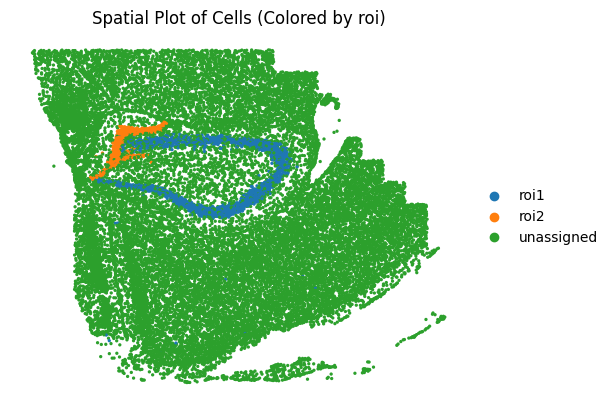

In [ ]:
color_by = "roi"
plt.figure(figsize=(10, 10))
sc.pl.spatial(adata, color=color_by, spot_size=30, show=False, frameon=False)
plt.title(f"Spatial Plot of Cells (Colored by {color_by if color_by else 'default'})")
plt.show()

d:\Programs\miniforge3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


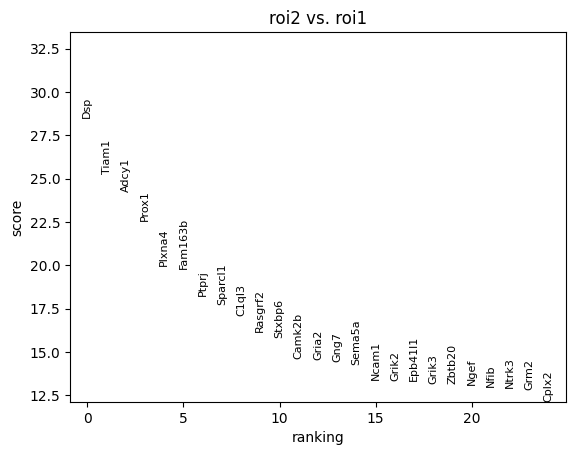

      names     scores  logfoldchanges          pvals      pvals_adj
0       Dsp  28.531996             NaN  4.698635e-179  4.510690e-176
1     Tiam1  25.250317             NaN  1.123519e-140  2.696446e-138
2     Adcy1  24.210752        5.965784  1.714129e-129  2.742607e-127
3     Prox1  22.560173             NaN  1.067054e-112  1.463389e-110
4    Plxna4  19.938423        2.067468   1.889277e-88   1.648823e-86
5   Fam163b  19.818302             NaN   2.069749e-87   1.655799e-85
6     Ptprj  18.236536        2.712364   2.647117e-74   1.694155e-72
7   Sparcl1  17.694166       -1.548157   4.650660e-70   2.480352e-68
8     C1ql3  17.052919             NaN   3.325023e-65   1.520010e-63
9   Rasgrf2  16.177561             NaN   7.261395e-59   2.788376e-57
10   Stxbp6  15.797760             NaN   3.223716e-56   1.146210e-54
11   Camk2b  14.612254        0.661665   2.346262e-48   7.766937e-47
12    Gria2  14.557001        0.958926   5.272067e-48   1.687062e-46
13     Gng7  14.403502        5.81

In [ ]:
import scanpy as sc
import pandas as pd

# First, subset to only cells in roi1 and roi2 (exclude unassigned)
adata_roi = adata_v2[adata_v2.obs["roi"].isin(["roi1", "roi2"])].copy()

# Run differential expression analysis
sc.tl.rank_genes_groups(
    adata_roi, 
    groupby='roi',  # Column containing your groups
    method='wilcoxon',  # or 't-test', 'logreg', 't-test_overestim_var'
    key_added='roi_deg',  # Key to store results
    reference='roi1',  # Compare roi2 vs roi1 (or use 'rest' for one-vs-rest)
    n_genes=None # Calculate for all genes
)

# View top DEGs
sc.pl.rank_genes_groups(adata_roi, key='roi_deg', n_genes=25, sharey=False)

# Get results as a DataFrame
# Top genes upregulated in roi2 compared to roi1
result = sc.get.rank_genes_groups_df(adata_roi, group='roi2', key='roi_deg')
print(result.head(20))

# Save full results
result.to_csv('roi2_vs_roi1_DEGs.csv', index=False)

# Filter by significance and fold change
significant_degs = result[
    (result['pvals_adj'] < 0.05) &  # Adjusted p-value threshold
    (abs(result['logfoldchanges']) > 0.5)  # Log fold change threshold
]
print(f"Number of significant DEGs: {len(significant_degs)}")